# Operation churn

### Goals

- Identify key drivers for customer churn
- Use drivers to develop a ML model that accurately predicts whether a customer has churned
- Provide Telco with key customer insights
- Provide at least one business recommendation which Telco can use to meet their business objectives

## Imports

In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import acquire
import prepare
import opchurn

import warnings
warnings.filterwarnings('ignore')

## Acquire

Data was acquired from telco_churn database provided by Codeup  
Database consists of 7,043 rows and 24 columns  
No null values observed at this point  
Total charges dtype is object, will have to convert to float during prep  

## Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Monthly Charges| The amount of money in USD a customer is charged per month (float)|
|Tenure| How long a customer has been with Telco (months)|
|Churn (target variable)| A customer has left Telco|
|No Churn| An active Telco customer|
|Internet Service Type| Whether a customer has DSL, Fiber optic, or None|
|Contract type| Whether a customer has a Month-to-month, One-year, or Two-year contract|
|EDA| Exploritory Data Analysis|


## Prepare

Utilized function to drop duplicate columns:  
payment_type_id  
internet_service_type_id  
contract_type_id  

Converted total_charges to float  
Discovered Null (blank space) values in total charges.  
Replaced null with 0:  
Since new customers have not been charged, the amount is 0  

In [2]:
# acquiring data
df = acquire.get_telco_data()

# cleaning and preparing data
df = prepare.prep_telco(df)

# splitting data into train, validate, test
train, validate, test = prepare.split_function(df, 'churn')

Found CSV


## EDA Process

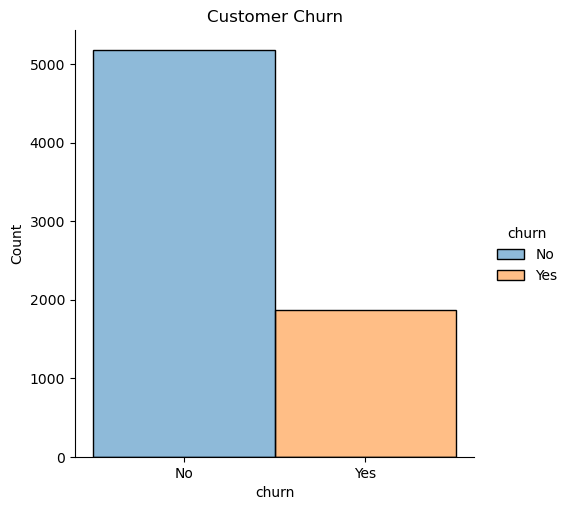

In [3]:
sns.displot(data=df, x='churn', hue='churn')
plt.title('Customer Churn')
plt.show()

**Before** exploring, I **split my data** set into *train, validate, test* and **ONLY** used *train* for exploration.  
I used a function imported from prepare.py file  

### Do monthly charges effect customer churn?

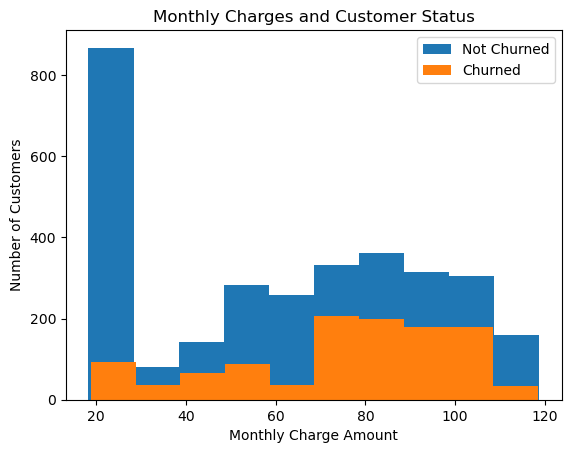

In [4]:
opchurn.get_monthly_charges_plot(train)

$H_0$: Mean of monthly charges of churned customers <= Mean of monthly charges of all customers  
$H_a$: Mean of monthly charges of churned customers > Mean of monthly charges of all customers  
1 sample 1 tail t-test

In [5]:
opchurn.get_monthly_charges_ttest(train)

t = 12.65
p = 1.074e-34
We reject the hypothesis


#### **Takeaway**:  
- We can infer that the mean of monthly charges for churned customers are higher than the mean of all customers.  
- Our test results showed that this is statistically significant.  
- I have verified this variable as a **key driver** for customer churn.

### Does internet service type effect customer churn?

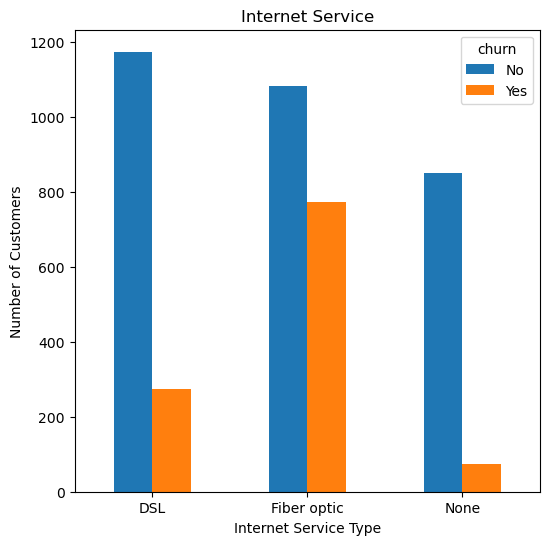

In [6]:
opchurn.get_internet_service_plot(train)

$H_0$: Customer Churn is independent of Internet service type  
$H_a$: Customer Churn is dependent on Internet service  
$Chi^2$ test

In [7]:
opchurn.get_internet_service_chi2(train)

chi^2 = 423.2590
p.    = 0.0000
We reject the null hypothesis


#### **Takeaway:**  
- Our test results indicate that internet service type and customer churn are statistically significant.  
- We can see from the graph that there is a high rate of fiber optic service for customers who churn.  
- I have been able to verify that internet service type is a **key driver** for customer churn.

### Does tenure effect customer churn?

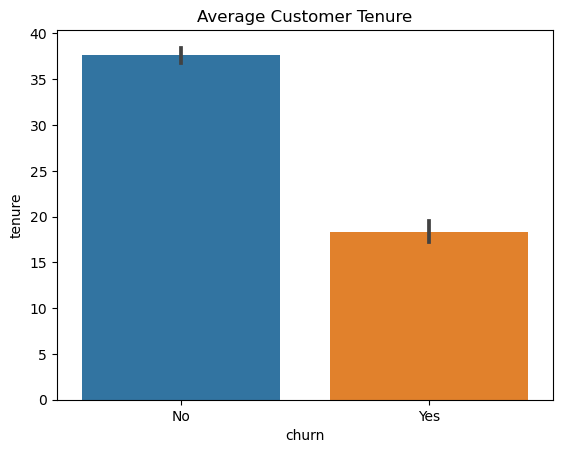

In [8]:
sns.barplot(data=train, x='churn', y='tenure')
plt.title('Average Customer Tenure')
plt.show()

$H_0$: Mean tenure of churned customers == Mean tenure of active customers  
$H_a$: Mean tenure of churned customers != Mean tenure of active customers  
t-test 2-tail

In [9]:
opchurn.get_tenure_ttest(train)

t= -26.58
p= 8.805e-137
We reject the null hypothesis


#### **Takeaway:**  
- We can infer that the mean tenure of active customers is higher than the mean tenure of customers who churn.  
- Average tenure for active customer is more than 2x's that of churned customers at ~37 months and ~18 months respectively.  
- Valuable insight is that the lifetime value of churned customers is half that of active customers making tenure another **key driver** of churn. 

### Does contract type effect customer churn?

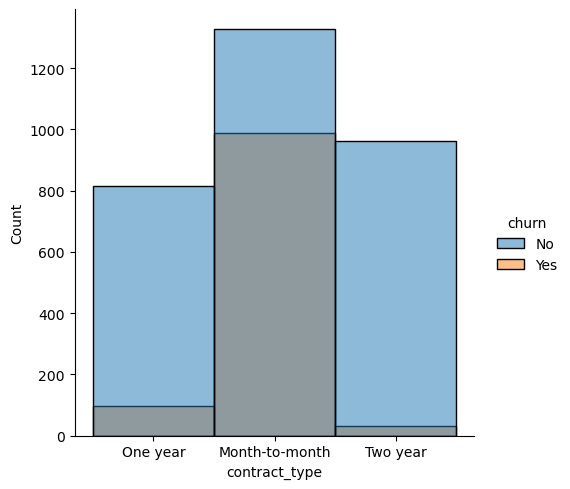

In [10]:
sns.displot(data=train, x='contract_type', hue='churn')
plt.show()

$H_0$: Customer Churn is independent of contract type  
$H_a$: Customer Churn is dependent on contract type  
$Chi^2$ test  

In [11]:
opchurn.get_contract_type_chi2(train)

chi^2 = 703.7871
p.    = 0.0000
We reject the null hypothesis


#### **Takeaway:**  
- Contract type does play a role in customer churn.  
- Month-to-month is the bulk of all contracts.  
- Month-to-month is 88% of contracts for customers who churn.  

### EDA Summary

**I answered 4 primary questions during the EDA phase of this project:**  

1. ***Does monthly charges effect customer churn?***  
2. ***Does internet service type effect customer churn?***  
3. ***Does tenure effect customer churn?***  
4. ***Does contract type effect customer churn?***  

The outcome for all 4 questions is **Yes**.  
I used all 4 features in the modeling phase.  
I was not surprised by the outcomes, I expected all 4 to play a role in customer churn. I wanted to test each to verify.  

## Modeling

### Introduction  

I used 3 ML algorithms:  
***Decision Tree*** , ***Random Forests***, & ***Logistic Regression***  
Evaluation Metric: Accuracy
- Once multiple iterations were ran for all 3 models, I picked the best model for each algorithm.  
    - I then picked the best performing model out of the top 3.

Features used in all Models:  
- **'tenure'**  (statistically significant in stats test)
- **'monthly_charges'**  (statistically significant in stats test)
- **'contract_type_One year' , 'contract_type_Two year'**  (statistically significant in stats test)
- **'internet_service_type_Fiber optic' , 'internet_service_type_None'** (statistically significant in stats test)
- **'tech_support_No internet service' , 'tech_support_Yes'** (Did not test this variable but did look significant for senior citizens)

In [12]:
# utilize function and save variables for first model
X_train, X_validate, X_test, y_train, y_validate, y_test = opchurn.Xy_train_val_test(train, validate, test, 'churn_Yes')

Baseline Accuracy: 73.47%


### Random Forest

In [13]:
opchurn.rand_forest_model(X_train, y_train, X_validate, y_validate)

   Train Accuracy: 80.83%
Validate Accuracy: 80.41%


- Random Forest accuracy performed above baseline for both train and validate.
    - Top 2 features with highest importance weight for model are ***tenure*** at ~36% and ***monthly charges*** at ~20%.

### Decision Tree

In [14]:
opchurn.decision_tree_model(X_train, y_train, X_validate, y_validate)

   Train Accuracy: 80.02%
Validate Accuracy: 79.91%


- Decision Tree accuracy performed above baseline for both train and validate but slightly less accurate than my Random Forest Model.
    - Top 2 features with highest importance weight for this model are ***tenure*** at ~52% and ***fiber optic internet service type*** at ~34%.

### Logistic Regression

In [15]:
opchurn.log_reg_model(X_train, y_train, X_validate, y_validate)

   Train Accuracy: 78.51%
Validate Accuracy: 79.77%


- Logistic Regression accuracy performed above baseline for both train and validate but less accurate than both Random Forest and Decision Tree models.

### Best model - Random Forest

In [18]:
rf = opchurn.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

Baseline Accuracy: 73.47%
   Train Accuracy: 80.83%
Validate Accuracy: 80.41%
   Test Accuracry: 79.42%


- Best model performed above baseline accuracy with train, validate, and test data. Test data is 1% below train and validate.

### Model Summary

- Decision Tree, Random Forest, and Logistic Regression models all performed above baseline on train and validate.  
- Random Forest and Decision Tree both scored ~80% on train and validate with Random Forest having slightly higher scores on both.  
- Logistic Regression had an accuracy of ~78.5% which was below both Random Forest and Decision Tree but above baseline.

## Conclusions

### Exploration  
- Identified and verified 4 **key drivers** of churn:
    - Monthly charges
    - Tenure
    - Internet service type (i.e. DSL, Fiber optic, None)
    - Contract type (i.e. Month-to-month, 1 year, 2 year)

### Modeling

Utilizing those key drivers of churn, my final model performed above baseline and had a Test accuracry of 79.42%

### Recommendations



#### 1. Revisit Telco value proposition:


- The cost of maintaining a customer is typically cheaper than the cost of acquiring a customer.  
    - Retaining customers for longer will increase the bottom line
- Explore additional add ons or subsidized subscription services for:
    - New customers AND 
    - Tenured customers
        - Both offers should be different with a perceived higher value for more tenured customers to extend their lifetime value. 
- Lean in and increase our competitive advantage.

#### 2. Dive into the competitor landscape to understand how that is affecting Telco:

- Is there a new competitor that our customers are jumping to?   
- Are competitors offering the same, less or more services for the same, lower, or higher price? (value proposition)  
- Do Telco competitors have features that Telco doesn't offer?  
    - If yes, can Telco incorporate similar features at low cost and minimal interruption to the current workforce?  
- Price is typically elastic in the telecommunications industry but don’t make a race to the bottom. There are other ways Telco can incentivize customers to stay longer. 


#### 3. Take a look inside the company:  
- An overwhelming majority of customers who churn have fiber internet and are paying higher monthly charges than the average customer.  
- Are there service interruptions for fiber service?  
- Is our fiber service not performing up to contract speeds?  
    - If yes, does Telco have the proper workforce in place to minimize interruptions or expedite maintenance fix issues? 
 


Monthly to month contracts naturally have higher churn rates.  
This industry has low entry and exit barriers which means it's easy for customer to switch back and forth between Telco and its competitors.

### Next Steps

- If I had more time I would have wanted to create a column of bundled service or add-ons and test the significance that variable would have on customer churn. My hypothesis on this is that customers who have a deeper relationship (more services) churn at a lower rate.

**Prediction CSV**

In [20]:
opchurn.create_csv(X_test, test, rf)